# Adaptive Variational Quantum Dynamics of Heisenberg model


In [1]:
import numpy as np
import os
import sys
import time
from model import zzxzmodel
from model import heis
from ansatz import ansatz
from avaridyn import avaridynIsing
from avaridyn import avaridynHeis
from ansatz import generate_op_pools
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit.opflow import Zero, One, I, X, Y, Z

## The initial setup

In [3]:
N=3 # The system size


start = time.time() 


nsite = N

# init_state = ([state for supersposition],[phase]) : phase e^(i\phi)
init_state_1 = ([3],[1]) #Create initial state 0-> [down,down,down], 1-> [up,down,down].....

# Make initial state at ref_state at t=0
ref_state = np.zeros((2**nsite),dtype=complex)

if len(init_state_1[0])==1:
    
    ref_state[init_state_1[0][0]] = 1
    
else:
    
    for i in range(len(init_state_1[0])):
        
        ref_state[init_state_1[0][i]]=init_state_1[1][i]/np.sqrt(len(init_state_1[0]))

## Build the model and run AVQDS for the model

In [5]:
ans = ansatz(nsite, ref_state = ref_state, pool='Heis', pthcut=9000) # Create Heisenberg operator pool: Rzz, Rxx, Ryy

# builds up the Hamiltonian model (see model.py)
model = heis(nsite=nsite, T=np.pi, Jzz_init = np.ones(nsite), Jxx_init= np.zeros(nsite), Jyy_init = np.zeros(nsite), hs_init = np.zeros(nsite), Jxx=1.0, Jyy=1.0, Jzz=1.0)
# T: the total evolution time. If one wan to get U(\pi/4), one can set it as np.pi/4


# The set up for time evolution with Hamiltonian
dyn = avaridynHeis(model, ans, quench_type = 1, init_state = init_state_1, dtmax=0.001, dthmax=0.01) 

dyn.run() # Run avqds simulator to find best parameters and operators for pseudo-Trotter time evolution. 
# (also save the file named as params_trace.dat and ansatz.h5)

In [6]:
target_t=np.pi # the evolution time we want to get. If one wan to get U(\pi/4), one can set it as np.pi/4
f = open("params_trace.DAT", "r") # open the variational parameters file
num_string = f.readline()
pi_closer = 0
del_num = 1000
while num_string != '': 
    num = num_string.split()
    time = float(num[0])

    if min(del_num,np.abs(time-target_t))==del_num:
        pass
    else:
        del_num=np.abs(time-target_t)
        pi_closer=time
        params=num[1:]
    num_string = f.readline()

print(params) # The variational parameters

['0.040738880032', '9.493652320021', '0.261749023042', '0.261749023042', '6.568806943890']


In [7]:
for i in range(len(params)):
    print('The '+str(i)+'th variational parameter are:', round(float(params[i]),4))
    
    if ans._ansatz[1][i][1] == 1:
    
        print('The corresponding Operator is XX('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')
    
    elif ans._ansatz[1][i][1] == 2:
        
        print('The corresponding Operator is YY('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')
        
    elif ans._ansatz[1][i][1] == 3:
        
        print('The corresponding Operator is ZZ('+str(ans._ansatz[1][i][0])+','+str(ans._ansatz[1][i][2])+')')

The 0th variational parameter are: 0.0407
The corresponding Operator is XX(0,1)
The 1th variational parameter are: 9.4937
The corresponding Operator is ZZ(1,2)
The 2th variational parameter are: 0.2617
The corresponding Operator is XX(1,2)
The 3th variational parameter are: 0.2617
The corresponding Operator is YY(1,2)
The 4th variational parameter are: 6.5688
The corresponding Operator is ZZ(0,1)


## Create the Quantum Variational Circuit

In [8]:
qc = QuantumCircuit(nsite) # create quantum circuit
qc.x([1,2])
for i,op in enumerate(ans._ansatz[1]):
    if op[1]==3:                             # op[1]=3: means Rzz gate
        qc.rzz(float(params[i]),op[0],op[2])
    elif op[1]==2:                           # op[1]=2: means Ryy gate
        qc.ryy(float(params[i]),op[0],op[2])
    elif op[1]==1:                           # # op[1]=1: means Rxx gate
        qc.rxx(float(params[i]),op[0],op[2])

## State Tomography Test on Simulator

In [9]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import state_fidelity
import warnings
warnings.filterwarnings('ignore')

In [10]:
st_qcs = state_tomography_circuits(qc,[0,1,2]) # create circuits for state tomography
backend = QasmSimulator(method='statevector')

In [11]:
reps=4
jobs = []
shots=8192
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    jobs.append(job)

In [12]:
def state_tomo(result, st_qcs): #, time):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    initial_state = One^One^Zero

    tomo_fitter = StateTomographyFitter(result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [13]:
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)#, target_time)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9957 ± 0.0009



# Quantum Simulation


In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

import qiskit

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [16]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

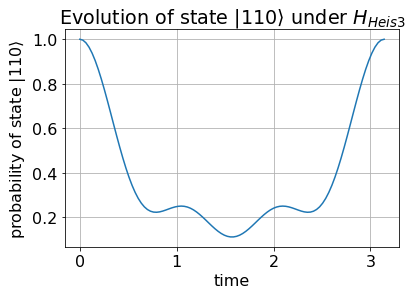

In [17]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero


# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

# Run on the Real device

In [ ]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag

from scipy.special import erf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load IBMQ Account data
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()



<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend  = provider.get_backend('ibmq_jakarta')

properties = backend.properties()

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [ ]:
# Use optimized pulse

# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

In [ ]:
import h5py
f_ansatz= h5py.File(ansatz_file, 'r') # open h5 file

## Rzz gate using qiskit's non echo Rzx

In [ ]:
def rzz_qiskit(qc,angle,q1,q0): # Using non-echo Rzx gate to create Rzz gate 
    qc.ry(-np.pi/2,q0)
    qc.rzx(angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1)             # X \pi echo pulse
    qc.rzx(-angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1)
    qc.ry(np.pi/2,q0)

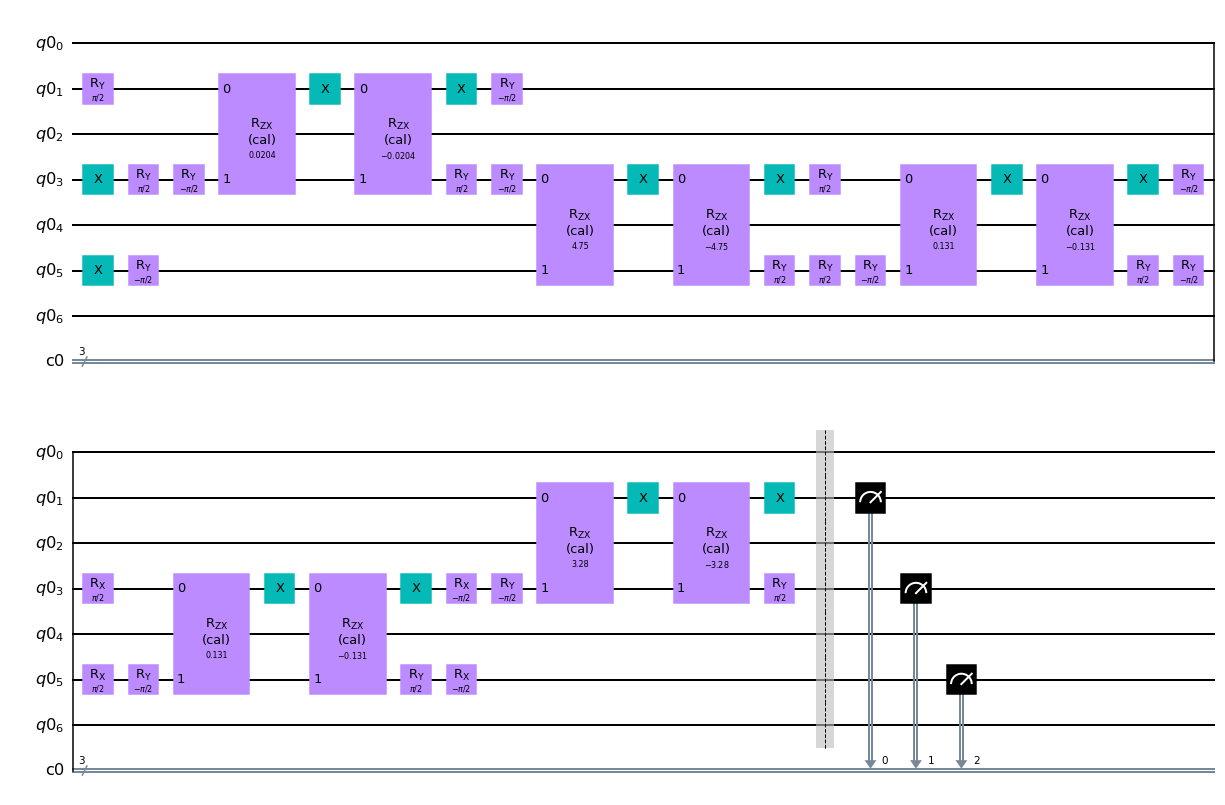

In [ ]:
target_time = np.pi 

target_t=np.pi # the evolution time we want to get 
f = open(params_file, "r") # open the variational parameters file
num_string = f.readline()
pi_closer = 0
del_num = 1000
while num_string != '': # find out variational parameters when t=target_t
    num = num_string.split()
    time = float(num[0])
    if min(del_num,np.abs(time-target_t))==del_num:
        pass
    else:
        del_num=np.abs(time-target_t)
        pi_closer=time
        params=num[1:]
    num_string = f.readline()


# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

qlst=[1,3,5] # Use 1,3,5 circuits

q0=qlst[0]

q1=qlst[1]

q2=qlst[2]


for i,op in enumerate(ans._ansatz[1]):
    if op[1]==3:
      # op[1]=3: means Rzz gate
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
    elif op[1]==2:
      # op[1]=2: means Ryy gate
        qc.rx(np.pi/2,[qlst[op[0]],qlst[op[2]]])
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
        qc.rx(-np.pi/2,[qlst[op[0]],qlst[op[2]]])
    elif op[1]==1:
      # # op[1]=1: means Rxx gate
        qc.ry(np.pi/2,[qlst[op[0]],qlst[op[2]]])
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
        qc.ry(-np.pi/2,[qlst[op[0]],qlst[op[2]]])


# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[q0], qr[q1], qr[q2]])

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])
st_qcs_pulse_efficient = pm.run(st_qcs)
st_qcs_pulse_efficient[-1].draw('mpl') # optimized the pulse sequence


## Dynamical decoupling

In [ ]:
def DD_circuit_qiskit_pulse(circuit, backend, qubits_list, initial_layout = None, name=False):
    """

    Dynamical decoupling X_\pi-X_-\pi 


    circuit: qiskit circuit

    backend: ibm device

    qubits_list: the qubit list used to run 

    name: 'the circuit name'

    """

    if initial_layout:

        circuit = transpile(circuit, backend, scheduling_method='asap',initial_layout =init_layout)

    else:

        circuit = transpile(circuit, backend, scheduling_method='asap')

    if name:

        DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

    else:

        DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)

    for operation in circuit[:]:

        if type(operation[0])==qiskit.circuit.delay.Delay:

            if  operation[0].duration >= 400:

                q_index = operation[1][0].index

                if q_index in qubits_list:

                    t=(operation[0].duration-320)//4 

                    t = math.ceil((t)/16)*16 # must be the multiple of 16

                    DD_cir.delay(t,[q_index],'dt')

                    DD_cir.x(q_index) # X_\pi

                    DD_cir.delay(2*t,[q_index],'dt')

                    DD_cir.z(q_index) # Z gate won't contribute time in ibm device

                    DD_cir.x(q_index) # X_-\pi

                    DD_cir.z(q_index) # Z gate won't contribute time in ibm device

                else:

                    DD_cir.data.append(operation)

            else:

                DD_cir.data.append(operation)

        else:

            DD_cir.data.append(operation)

    pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])
    DD_cir_pulse_efficient = pm.run(DD_cir)

    return DD_cir_pulse_efficient

In [ ]:
from qiskit import *

In [ ]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [ ]:
qubits_list = [1,3,5]

cirs=[]

# create the circuits w/ dynamical decoupling.
for i in range(len(st_qcs)):

    cir_pulse_efficient=DD_circuit_qiskit_pulse(st_qcs_pulse_efficient[i], backend, qubits_list, name=True )

    cirs.append(cir_pulse_efficient)

## Readout Error Mitigation 

In [ ]:
# Using complete readout error mitigation
qubits_list = [q0,q1,q2]

shots=8192

qr = QuantumRegister(len(qubits_list),'q')

meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:
# Execute the readout error mitigation circuits first
init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j

cal_results = execute(meas_calibs, backend, shots=shots, initial_layout=init_layout)

print('Job ID', cal_results.job_id())

Job ID 624cf6f6182d0264174c1d8b


In [ ]:
shots = 8192
reps =8

backend = backend 

jobs = []
for _ in range(reps):
    # execute state tomography circuits
    job = execute(cirs, backend, shots=shots)
    
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 624cf6facaa265439af18d92
Job ID 624cf6fd5ab79bc22af94560
Job ID 624cf70073968c7dec07a6b6
Job ID 624cf70273968c4e5707a6b7
Job ID 624cf706182d02762a4c1d8d
Job ID 624cf709d72033ee1567cc01
Job ID 624cf70ccaa2658fb7f18d94
Job ID 624cf70f5ab79b306af94562


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job is queued (536)

# Job Retrieve

In [ ]:
# The history result


# Readout error mitigation result
cal_results=backend.retrieve_job('624cf6f6182d0264174c1d8b')

# State tomography result
ids=['624cf6facaa265439af18d92','624cf6fd5ab79bc22af94560','624cf70073968c7dec07a6b6','624cf70273968c4e5707a6b7',
     '624cf706182d02762a4c1d8d','624cf709d72033ee1567cc01','624cf70ccaa2658fb7f18d94','624cf70f5ab79b306af94562']
jobs=[]
for id in ids:
    jobs.append(backend.retrieve_job(id))

## Results

In [ ]:
# get readout error filter
meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs): #, time):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    initial_state = One^One^Zero

    #target_state = (U_heis3(float(time)) @ initial_state).eval().to_matrix()

    mit_result = meas_fitter.filter.apply(result)

    tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition

fids = []

for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids))) 

state tomography fidelity = 0.9342 ± 0.0025


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table